# Scenario 1: All modalities exists, no heterginity

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import seaborn as sns
import networkx as nx

Data Overview:
   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0   0.421776   0.574011   0.599583   0.479369   0.509436   0.519414   
1   0.086067   0.148184   0.152437   0.115488   0.161196   0.144720   
2   0.280018   0.396211   0.411088   0.327705   0.365325   0.362988   
3   0.044752   0.091481   0.096576   0.066178   0.111749   0.093948   
4   0.435670   0.591882   0.617901   0.494919   0.525206   0.535559   

   Feature_7  Feature_8  Feature_9  Feature_10  ...  Feature_248  Feature_249  \
0   0.574690   0.495442   0.531326    0.494106  ...     3.955962    -2.599507   
1   0.154916   0.172746   0.145424    0.130367  ...     1.416205     2.409825   
2   0.399500   0.365175   0.371011    0.344062  ...    -1.774577     0.417372   
3   0.097663   0.119082   0.093101    0.079053  ...     1.845771    -6.682148   
4   0.592540   0.511974   0.548630    0.510616  ...    -1.638498     0.237464   

   Feature_250  Feature_251  Feature_252  Feature_253  Feature_254  \
0

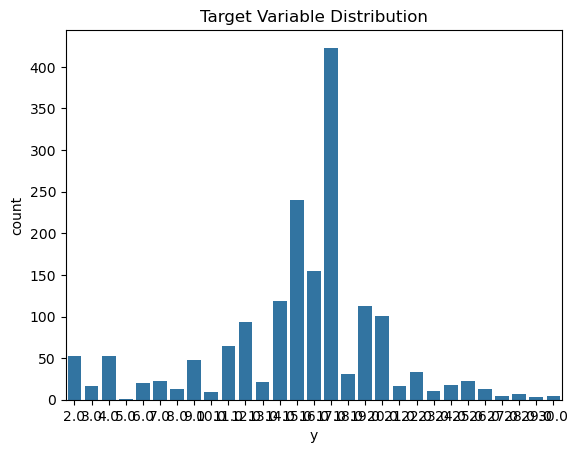

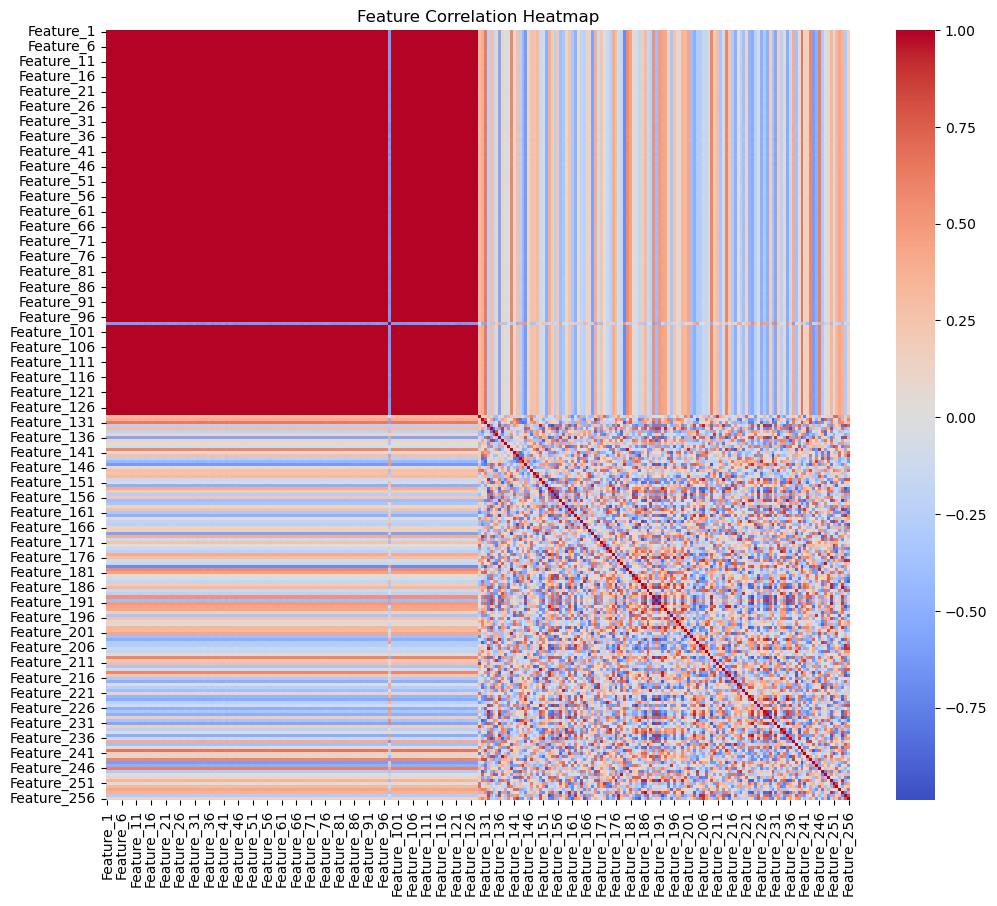

In [2]:
# Set random seed for reproducibility
seed = 42  # You can choose any integer here

# Set seed for NumPy
np.random.seed(seed)

# Set seed for Python's random module
random.seed(seed)

# Set seed for PyTorch
torch.manual_seed(seed)

# For GPU (if using CUDA)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

# Set deterministic behavior for reproducibility in case of CUDA operations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False






# Directory containing the saved CSV files
output_dir = "datasets/FL/training_outputs/"

# Load one of the CSV files for EDA (e.g., user_0_outputs.csv)
csv_file = os.path.join(output_dir, "user_1_outputs.csv")
df = pd.read_csv(csv_file)

# Quick overview of the data
print("Data Overview:")
print(df.head())
print("\nData Summary:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Distribution of the target variable (y)
sns.countplot(x="y", data=df)
plt.title("Target Variable Distribution")
plt.show()

# Correlation heatmap of features
correlation_matrix = df.iloc[:, :-1].corr()  # Exclude the target column
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

In [3]:
no_users = 20
# Define the Multinomial Logistic Regression model
class MultinomialLogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MultinomialLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)

# Custom dataset to load the data from CSV
class CustomDataset(Dataset):
    def __init__(self,  csv_file, modality=["pos_height", "images"], scaler=None, zero_prob=0.5):
        self.data = pd.read_csv(csv_file)
        if "images" in modality and "pos_height" in modality:
            self.X = self.data.iloc[:, :-1].values  # Features
            mask = np.ones(self.X.shape)  # Initialize mask
            mask[:, 128:-1] = np.random.choice([0, 1], size=self.X[:, 128:-1].shape, p=[zero_prob, 1 - zero_prob])
            self.X *= mask  # Apply mask to zero out features
        elif "images" in modality:
            self.X = self.data.iloc[:, 128:-1].values  # Features
            mask = np.random.choice([0, 1], size=self.X.shape, p=[zero_prob, 1 - zero_prob])  # Create a binary mask
            self.X *= mask  # Apply mask
        else:
            self.X = self.data.iloc[:, 0:128].values  # Features

        self.y = self.data.iloc[:, -1].values   # Labels

        # If a scaler is provided, use it to transform the features
        if scaler:
            self.X = scaler.transform(self.X)
        else:
            # Fit the scaler on the training data and transform
            self.scaler = MinMaxScaler(feature_range=(-1, 1))
            self.X = self.scaler.fit_transform(self.X)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.long)  # Use long for classification targets
        return X, y



In [4]:
# Configuration
no_users = 20  # Example: Number of users
available_modalities = ["pos_height", "images"]
modality_size = {"pos_height": 128, "images": 128}
group_definitions = {
    1: ["pos_height"],        # Group 1: Only pos_height
    2: ["images"],            # Group 2: Only images
    3: ["pos_height", "images"]  # Group 3: Both modalities
}

# Assign each user to a group randomly
user_groups = [random.choice([1, 2, 3]) for _ in range(no_users)]

# Assign modalities to users based on their group
user_modalities = [group_definitions[group] for group in user_groups]

# Compute output sizes for each user based on their modalities
output_sizes = [sum(modality_size[modality] for modality in user_modality) for user_modality in user_modalities]

# Store models (placeholders for actual models)
all_models = []

# Example output (for verification)
print(f"User Groups: {user_groups[:10]}")  # Show first 10 users' groups
print(f"User Modalities: {user_modalities[:10]}")  # Show first 10 users' modalities
print(f"Output Sizes: {output_sizes[:10]}")  # Show first 10 users' output sizes

User Groups: [3, 1, 1, 3, 2, 1, 1, 1, 3, 1]
User Modalities: [['pos_height', 'images'], ['pos_height'], ['pos_height'], ['pos_height', 'images'], ['images'], ['pos_height'], ['pos_height'], ['pos_height'], ['pos_height', 'images'], ['pos_height']]
Output Sizes: [256, 128, 128, 256, 128, 128, 128, 128, 256, 128]


In [5]:
no_users = 20
# List to store DataLoader objects for each user
train_loaders = []
val_loaders = []
test_loaders = []
scaler = None
# Loop over each user
zero_prob=0.9
dataset_dir = "datasets/FL/"
for user_idx in range(no_users):
    scaler = None
    # Define file paths for each user dynamically
    train_file = dataset_dir + f"training_outputs/user_{user_idx}_outputs.csv"
    val_file = dataset_dir + f"val_outputs/user_{user_idx}_outputs.csv"
    test_file = dataset_dir + f"test_outputs/user_{user_idx}_outputs.csv"

    # Load training data and fit the scaler on it (only once for each user)
    train_data = pd.read_csv(train_file)
    
    if scaler is None:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        # Fit the scaler on the first user's training data
        if "images" in user_modalities[user_idx] and "pos_height" in user_modalities[user_idx]:
            temp = train_data.iloc[:, :-1].values  # Features
        elif "images" in user_modalities[user_idx]:
            temp = train_data.iloc[:, 128:-1].values  # Features
        else:
            temp = train_data.iloc[:, 0:128].values  # Features
        scaler.fit(temp)  # Fit scaler only on training features

    # Create datasets using the same scaler for all data
    train_dataset = CustomDataset(train_file, scaler=scaler, modality=user_modalities[user_idx], zero_prob=0.5)
    val_dataset = CustomDataset(val_file, scaler=scaler, modality=user_modalities[user_idx], zero_prob=0.5)
    test_dataset = CustomDataset(test_file, scaler=scaler, modality=user_modalities[user_idx], zero_prob=0.5)

    # Create DataLoader for training, validation, and testing for each user
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Append each user's DataLoader to the respective lists
    train_loaders.append(train_loader)
    val_loaders.append(val_loader)
    test_loaders.append(test_loader)

In [6]:
# Initialize model, loss function, and optimizer for multiple users
input_sizes = output_sizes  # Number of features
num_classes = 64
classifiers = [MultinomialLogisticRegression(input_size, num_classes).cuda()  for input_size, _ in zip(input_sizes, range(no_users))]
#classifiers = [MultinomialLogisticRegression(input_size, num_classes).cuda() for _ in range(no_users)]
optimizers = [optim.SGD(model.parameters(), lr=0.01) for model in classifiers]
criterion = nn.CrossEntropyLoss()
# Training parameters
num_epochs = 100

In [7]:
def sinkhorn_knopp(matrix, tol=1e-9, max_iter=1000):
    """
    Converts a given matrix to a doubly stochastic matrix using the Sinkhorn-Knopp algorithm.
    
    Parameters:
        matrix (np.ndarray): The input matrix to be transformed.
        tol (float): The tolerance for convergence.
        max_iter (int): Maximum number of iterations for convergence.
    
    Returns:
        np.ndarray: A doubly stochastic matrix.
    """
    matrix = matrix.copy()
    for _ in range(max_iter):
        # Normalize rows
        row_sums = matrix.sum(axis=1, keepdims=True)
        matrix /= row_sums

        # Normalize columns
        col_sums = matrix.sum(axis=0, keepdims=True)
        matrix /= col_sums

        # Check for convergence
        if np.allclose(matrix.sum(axis=1), 1, atol=tol) and np.allclose(matrix.sum(axis=0), 1, atol=tol):
            break

    return matrix
    
def create_random_topology(num_users, edge_probability=0.3):
    """
    Creates a connected random topology using NetworkX.
    Returns the adjacency matrix.
    """
    while True:
        graph = nx.erdos_renyi_graph(num_users, edge_probability)
        if nx.is_connected(graph):
            break

    # Convert graph to adjacency matrix
    adjacency_matrix = nx.to_numpy_array(graph)
    return adjacency_matrix

def prepare_mixing_matrices(adjacency_matrix, similarity_matrices):
    """
    Computes a mixing matrix for each modality by multiplying the adjacency matrix 
    with the similarity matrix for that modality.
    Returns a dictionary of mixing matrices.
    """
    adjacency_matrices = {}
    mixing_matrices = {}
    for modality, similarity_matrix in similarity_matrices.items():
        # Element-wise multiplication of adjacency and similarity matrices
        combined_matrix = adjacency_matrix * similarity_matrix
        adjacency_matrices[modality] = combined_matrix
        
        # Normalize to create a doubly matrix
        mixing_matrix = sinkhorn_knopp(combined_matrix)
        
        
        mixing_matrices[modality] = mixing_matrix
    
    return mixing_matrices, adjacency_matrices




In [8]:
# Create random connected topology
#adjacency_matrix = create_random_topology(no_users, edge_probability=0.3)
# Initialize adjacency matrix
adjacency_matrix = np.zeros((no_users, no_users), dtype=int)

# Construct the adjacency matrix
for i in range(no_users):
    for j in range(no_users):
        if i != j:  # No self-loops
            # Check if users i and j share any modalities
            if set(user_modalities[i]) & set(user_modalities[j]):
                adjacency_matrix[i, j] = 1

# Display the adjacency matrix
print("Adjacency Matrix:")
print(adjacency_matrix)

# Prepare mixing matrices for each modality
#mixing_matrices, adjacency_matrices = prepare_mixing_matrices(adjacency_matrix, similarity_matrices)


Adjacency Matrix:
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1]
 [1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 0 0]
 [1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1]
 [1 0 0 1 1 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0]
 [1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1]
 [1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1]
 [1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1]
 [1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]]


# FMTL Training

In [9]:
factor = 0.05
neighbors = [np.nonzero(adjacency_matrix[i])[0].tolist() for i in range(no_users)]

# Initialize P_ij matrices
# Initialize P_ij matrices
P = {}
for i, j in zip(*adjacency_matrix.nonzero()):
    num_params_i = sum(p.numel() for p in classifiers[i].parameters())
    num_params_j = sum(p.numel() for p in classifiers[j].parameters())
    P[(i, j)] = torch.randn(int(factor*(num_params_i + num_params_j) // 2), num_params_i).cuda()
    P[(j, i)] = torch.randn(int(factor*(num_params_i + num_params_j) // 2), num_params_j).cuda()


In [10]:
def validate_user_model_FMTL(user_id, user_models, client_model, val_loader, loss_func):


    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    # Disable gradient computation for validation
    with torch.no_grad():
        # Set all models to evaluation mode
        client_model.eval()
        for model in user_models.values():
            model.eval()

        for X_batch, y_batch in val_loader:
            # Concatenate outputs from all modality models
            modality_outputs = []
            y_batch = y_batch.cuda()

            for modality, model in user_models.items():

                # Forward pass through modality model
                data = X_batch[modality].cuda()
                modality_output, _ = model(data)
                modality_outputs.append(modality_output)

            # Skip if no valid modalities are present
            if len(modality_outputs) == 0:
                print(f"No valid modalities for User {user_id + 1}, skipping batch.")
                continue

            # Concatenate all modality outputs
            concatenated_output = torch.cat(modality_outputs, dim=1)

            # Forward pass through the classifier
            predictions = client_model(concatenated_output)

            # Compute loss
            loss = loss_func(client_model, concatenated_output, y_batch, l2_strength=0.01)
            total_loss += loss.item() * y_batch.size(0)

            # Compute accuracy
            _, predicted = torch.max(predictions, 1)
            total_correct += (predicted == y_batch).sum().item()
            total_samples += y_batch.size(0)

    # Compute overall metrics
    avg_loss = total_loss / total_samples if total_samples > 0 else 0.0
    accuracy = total_correct / total_samples if total_samples > 0 else 0.0

    print(f"User {user_id + 1} - Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    return {'loss': avg_loss, 'accuracy': accuracy}


In [12]:
local_epochs = 1
global_rounds = 100
weight_decay = 1e-5
criterion = nn.CrossEntropyLoss()
alpha = 0.001
lambda_reg = 0.01
eta = 0.001
from utils import cross_entropy_loss_with_l2

# Initialize dictionaries to track group-level metrics
group_train_loss_histories = {1: [], 2: [], 3: []}
group_train_accuracy_histories = {1: [], 2: [], 3: []}
group_val_loss_histories = {1: [], 2: [], 3: []}
group_val_accuracy_histories = {1: [], 2: [], 3: []}

# Decentralized Training Loop
for epoch in range(global_rounds):
    print(f"Global Round {epoch + 1}")
    epoch_group_train_losses = {1: [], 2: [], 3: []}
    epoch_group_train_accuracies = {1: [], 2: [], 3: []}
    epoch_group_val_losses = {1: [], 2: [], 3: []}
    epoch_group_val_accuracies = {1: [], 2: [], 3: []}

    # Perform FMTL aggregation
    for user_id, (client_model, optimizer) in enumerate(zip(classifiers, optimizers)):
        group = user_groups[user_id]  # User's group
        epoch_train_loss = 0.0
        correct_train_predictions = 0
        total_train_samples = 0

        # Training phase
        client_model.train()
        for X_batch, y_batch in train_loaders[user_id]:
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

            optimizer.zero_grad()
            predictions = client_model(X_batch)
            loss = criterion(predictions, y_batch)#criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            _, predicted = torch.max(predictions, dim=1)
            correct_train_predictions += (predicted == y_batch).sum().item()
            total_train_samples += y_batch.size(0)

        avg_train_loss = epoch_train_loss / len(train_loaders[user_id])
        train_accuracy = correct_train_predictions / total_train_samples

        # FMTL-specific parameter updates
        with torch.no_grad():
            theta_i = torch.cat([param.view(-1) for param in client_model.parameters()])
            sum_P_terms = torch.zeros_like(theta_i)

            for j in range(no_users):
                if adjacency_matrix[user_id, j] == 1:
                    P_ij = P[(user_id, j)]
                    P_ji = P[(j, user_id)]
                    theta_j = torch.cat([param.view(-1) for param in classifiers[j].parameters()])
                    sum_P_terms += P_ij.T @ (P_ij @ theta_i - P_ji @ theta_j)

            theta_i -= 0#alpha * lambda_reg * sum_P_terms

            idx = 0
            for param in client_model.parameters():
                numel = param.numel()
                param.data.copy_(theta_i[idx:idx+numel].reshape(param.size()))
                idx += numel

            for j in range(no_users):
                if adjacency_matrix[user_id, j] == 1:
                    P_ij = P[(user_id, j)]
                    P_ji = P[(j, user_id)]
                    theta_j = torch.cat([param.view(-1) for param in classifiers[j].parameters()])
                    P[(user_id, j)] -= eta * lambda_reg * torch.outer(P_ij @ theta_i - P_ji @ theta_j, theta_i)

        # Validation phase
        epoch_val_loss = 0.0
        correct_val_predictions = 0
        total_val_samples = 0
        client_model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loaders[user_id]:
                X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
                outputs = client_model(X_batch)
                loss = criterion(outputs, y_batch)

                epoch_val_loss += loss.item()
                _, predicted = torch.max(outputs, dim=1)
                correct_val_predictions += (predicted == y_batch).sum().item()
                total_val_samples += y_batch.size(0)

        avg_val_loss = epoch_val_loss / len(val_loaders[user_id])
        val_accuracy = correct_val_predictions / total_val_samples

        # Assign user metrics to the respective group
        epoch_group_train_losses[group].append(avg_train_loss)
        epoch_group_train_accuracies[group].append(train_accuracy)
        epoch_group_val_losses[group].append(avg_val_loss)
        epoch_group_val_accuracies[group].append(val_accuracy)

    # Calculate group averages for this round
    for group in [1, 2, 3]:
        group_train_loss_histories[group].append(np.mean(epoch_group_train_losses[group]))
        group_train_accuracy_histories[group].append(np.mean(epoch_group_train_accuracies[group]))
        group_val_loss_histories[group].append(np.mean(epoch_group_val_losses[group]))
        group_val_accuracy_histories[group].append(np.mean(epoch_group_val_accuracies[group]))

    # Print group-wise average metrics
    print(f"Epoch [{epoch+1}/{global_rounds}] Group Metrics:")
    for group in [1, 2, 3]:
        print(f"  Group {group} - Train Loss: {group_train_loss_histories[group][-1]:.4f}, Train Accuracy: {group_train_accuracy_histories[group][-1]:.4f}")
        print(f"  Group {group} - Val Loss: {group_val_loss_histories[group][-1]:.4f}, Val Accuracy: {group_val_accuracy_histories[group][-1]:.4f}")


Global Round 1


C:\Users\abdu_\AppData\Local\Temp\ipykernel_31076\3432764924.py:42: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[idx], dtype=torch.long)  # Use long for classification targets


Epoch [1/100] Group Metrics:
  Group 1 - Train Loss: 3.3064, Train Accuracy: 0.2612
  Group 1 - Val Loss: 3.3154, Val Accuracy: 0.2611
  Group 2 - Train Loss: 1.8870, Train Accuracy: 0.5494
  Group 2 - Val Loss: 2.0225, Val Accuracy: 0.5029
  Group 3 - Train Loss: 1.8804, Train Accuracy: 0.5609
  Group 3 - Val Loss: 1.8727, Val Accuracy: 0.5644
Global Round 2
Epoch [2/100] Group Metrics:
  Group 1 - Train Loss: 3.2872, Train Accuracy: 0.2619
  Group 1 - Val Loss: 3.2963, Val Accuracy: 0.2610
  Group 2 - Train Loss: 1.8571, Train Accuracy: 0.5564
  Group 2 - Val Loss: 1.9945, Val Accuracy: 0.5076
  Group 3 - Train Loss: 1.8410, Train Accuracy: 0.5687
  Group 3 - Val Loss: 1.8365, Val Accuracy: 0.5712
Global Round 3
Epoch [3/100] Group Metrics:
  Group 1 - Train Loss: 3.2686, Train Accuracy: 0.2624
  Group 1 - Val Loss: 3.2777, Val Accuracy: 0.2623
  Group 2 - Train Loss: 1.8290, Train Accuracy: 0.5622
  Group 2 - Val Loss: 1.9679, Val Accuracy: 0.5099
  Group 3 - Train Loss: 1.8047, Tra

In [ ]:
# Convert metrics to numpy arrays for easy manipulation
group_train_loss_histories = {k: np.array(v) for k, v in group_train_loss_histories.items()}
group_train_accuracy_histories = {k: np.array(v) for k, v in group_train_accuracy_histories.items()}
group_val_loss_histories = {k: np.array(v) for k, v in group_val_loss_histories.items()}
group_val_accuracy_histories = {k: np.array(v) for k, v in group_val_accuracy_histories.items()}

# Handle potential one-dimensional arrays
group_train_loss_mean = {k: v.mean(axis=0) if v.ndim > 1 else v for k, v in group_train_loss_histories.items()}
group_train_loss_std = {k: v.std(axis=0) if v.ndim > 1 else np.zeros_like(v) for k, v in group_train_loss_histories.items()}
group_val_loss_mean = {k: v.mean(axis=0) if v.ndim > 1 else v for k, v in group_val_loss_histories.items()}
group_val_loss_std = {k: v.std(axis=0) if v.ndim > 1 else np.zeros_like(v) for k, v in group_val_loss_histories.items()}

group_train_acc_mean = {k: v.mean(axis=0) if v.ndim > 1 else v for k, v in group_train_accuracy_histories.items()}
group_train_acc_std = {k: v.std(axis=0) if v.ndim > 1 else np.zeros_like(v) for k, v in group_train_accuracy_histories.items()}
group_val_acc_mean = {k: v.mean(axis=0) if v.ndim > 1 else v for k, v in group_val_accuracy_histories.items()}
group_val_acc_std = {k: v.std(axis=0) if v.ndim > 1 else np.zeros_like(v) for k, v in group_val_accuracy_histories.items()}

# Combined Plot for All Modalities
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)
for group in [1, 2, 3]:
    plt.plot(range(1, num_epochs + 1), group_train_loss_mean[group], label=f"Group {group} Train Loss")
    plt.fill_between(range(1, num_epochs + 1), 
                     group_train_loss_mean[group] - group_train_loss_std[group], 
                     group_train_loss_mean[group] + group_train_loss_std[group], 
                     alpha=0.2)
    plt.plot(range(1, num_epochs + 1), group_val_loss_mean[group], label=f"Group {group} Validation Loss", linestyle="dashed")
    plt.fill_between(range(1, num_epochs + 1), 
                     group_val_loss_mean[group] - group_val_loss_std[group], 
                     group_val_loss_mean[group] + group_val_loss_std[group], 
                     alpha=0.2)

plt.title("Loss over Epochs for All Groups")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# Accuracy Plot
plt.subplot(1, 2, 2)
for group in [1, 2, 3]:
    plt.plot(range(1, num_epochs + 1), group_train_acc_mean[group], label=f"Group {group} Train Accuracy")
    plt.fill_between(range(1, num_epochs + 1), 
                     group_train_acc_mean[group] - group_train_acc_std[group], 
                     group_train_acc_mean[group] + group_train_acc_std[group], 
                     alpha=0.2)
    plt.plot(range(1, num_epochs + 1), group_val_acc_mean[group], label=f"Group {group} Validation Accuracy", linestyle="dashed")
    plt.fill_between(range(1, num_epochs + 1), 
                     group_val_acc_mean[group] - group_val_acc_std[group], 
                     group_val_acc_mean[group] + group_val_acc_std[group], 
                     alpha=0.2)

plt.title("Accuracy over Epochs for All Groups")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])  # Ensure y-axis is between 0 and 1 for accuracy
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
num_groups = 3
# Track metrics across all groups
group_test_loss_histories = {group: [] for group in range(1, num_groups + 1)}
group_test_accuracy_histories = {group: [] for group in range(1, num_groups + 1)}
group_train_loss_histories = {group: [] for group in range(1, num_groups + 1)}
group_train_accuracy_histories = {group: [] for group in range(1, num_groups + 1)}

with torch.no_grad():  # Disable gradient computation for testing
    for group in range(1, num_groups + 1):
        user_test_losses = []
        user_test_accuracies = []
        user_train_losses = []
        user_train_accuracies = []

        for user_id, model in enumerate(classifiers_by_group[group]):
            model.eval()

            # Test metrics
            epoch_test_loss = 0.0
            correct_test_predictions = 0
            total_test_samples = 0

            # Train metrics (optional, for post-training evaluation on training data)
            epoch_train_loss = 0.0
            correct_train_predictions = 0
            total_train_samples = 0

            # Evaluate on test set
            for X_batch, y_batch in test_loaders_by_group[group][user_id]:
                X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                epoch_test_loss += loss.item()
                _, predicted = torch.max(outputs, dim=1)
                correct_test_predictions += (predicted == y_batch).sum().item()
                total_test_samples += y_batch.size(0)

            # Evaluate on training set
            for X_batch, y_batch in train_loaders_by_group[group][user_id]:
                X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                epoch_train_loss += loss.item()
                _, predicted = torch.max(outputs, dim=1)
                correct_train_predictions += (predicted == y_batch).sum().item()
                total_train_samples += y_batch.size(0)

            # Calculate averages
            avg_test_loss = epoch_test_loss / len(test_loaders_by_group[group][user_id])
            test_accuracy = correct_test_predictions / total_test_samples

            avg_train_loss = epoch_train_loss / len(train_loaders_by_group[group][user_id])
            train_accuracy = correct_train_predictions / total_train_samples

            # Store metrics for each user
            user_test_losses.append(avg_test_loss)
            user_test_accuracies.append(test_accuracy)
            user_train_losses.append(avg_train_loss)
            user_train_accuracies.append(train_accuracy)

        # Store group-level metrics
        group_test_loss_histories[group].append(np.mean(user_test_losses))
        group_test_accuracy_histories[group].append(np.mean(user_test_accuracies))
        group_train_loss_histories[group].append(np.mean(user_train_losses))
        group_train_accuracy_histories[group].append(np.mean(user_train_accuracies))

# Convert metrics to numpy arrays for plotting
group_test_loss_histories = {group: np.array(values) for group, values in group_test_loss_histories.items()}
group_test_accuracy_histories = {group: np.array(values) for group, values in group_test_accuracy_histories.items()}
group_train_loss_histories = {group: np.array(values) for group, values in group_train_loss_histories.items()}
group_train_accuracy_histories = {group: np.array(values) for group, values in group_train_accuracy_histories.items()}

# Plot results for all groups
plt.figure(figsize=(12, 6))

# Test Loss and Accuracy
plt.subplot(1, 2, 1)
for group in range(1, num_groups + 1):
    plt.plot(range(1, len(group_test_loss_histories[group]) + 1), group_test_loss_histories[group], label=f"Group {group} Test Loss")
plt.title("Test Loss Across Groups")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
for group in range(1, num_groups + 1):
    plt.plot(range(1, len(group_test_accuracy_histories[group]) + 1), group_test_accuracy_histories[group], label=f"Group {group} Test Accuracy")
plt.title("Test Accuracy Across Groups")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
import json

metrics = {
    "FMTL_train_loss_histories": train_loss_histories.tolist(),
    "FMTL_train_accuracy_histories": train_accuracy_histories.tolist(),
    "FMTL_val_loss_histories": val_loss_histories.tolist(),
    "FMTL_val_accuracy_histories": val_accuracy_histories.tolist(),
    "FMTL_test_loss_histories": test_loss_histories.tolist(),
    "FMTL_test_accuracy_histories": test_accuracy_histories.tolist(),
}

with open("FMTL_metrics.json", "w") as f:
    json.dump(metrics, f)
print("FMTL_metrics.json")

In [ ]:
# Load metrics from JSON file
with open("metrics.json", "r") as f:
    metrics = json.load(f)

# Convert lists back to numpy arrays
train_loss_histories = np.array(metrics["train_loss_histories"])
train_accuracy_histories = np.array(metrics["train_accuracy_histories"])
val_loss_histories = np.array(metrics["val_loss_histories"])
val_accuracy_histories = np.array(metrics["val_accuracy_histories"])
test_loss_histories = np.array(metrics["test_loss_histories"])
test_accuracy_histories = np.array(metrics["test_accuracy_histories"])
# Print shapes to confirm loading
print("Train Loss Histories Shape:", train_loss_histories.shape)
print("Train Accuracy Histories Shape:", train_accuracy_histories.shape)
print("Validation Loss Histories Shape:", val_loss_histories.shape)
print("Validation Accuracy Histories Shape:", val_accuracy_histories.shape)
print("Test Loss Histories Shape:", test_loss_histories.shape)
print("Test Accuracy Histories Shape:", test_accuracy_histories.shape)